In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_columns('station');

# Exploratory Climate Analysis

## Precipitation Analysis

###  Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Utility function to adjust year value of a date value
# Inputs : date - String value for date in ISO format %Y-%M-%D
#          delta - Integer, +/-
import datetime as dt
def date_year_delta (date, delta) :
    try :
        qd = dt.datetime.strptime(date, '%Y-%m-%d')  # Usable format for the date
        return dt.datetime(qd.year+delta, qd.month, qd.day).strftime('%Y-%m-%d') # adjust year
    except ValueError :
        return date  # If error, return input date value

In [12]:
# Calculate the date 1 year ago from the last data point in the database

# Most recent date from table
max_date = session.query(func.max(Measurement.date)).scalar()

#Adjust the year by -1
query_date = date_year_delta (max_date, -1)

print(max_date, query_date)

2017-08-23 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement).filter(Measurement.date >= query_date)

# Sample the query result  [Use "for row in query :" for full query result]
for row in query.limit(10) :
    print (row.date, row.prcp, row.tobs)

2016-08-23 0.0 81.0
2016-08-24 0.08 79.0
2016-08-25 0.08 80.0
2016-08-26 0.0 79.0
2016-08-27 0.0 77.0
2016-08-28 0.01 78.0
2016-08-29 0.0 78.0
2016-08-30 0.0 79.0
2016-08-31 0.13 80.0
2016-09-01 0.0 81.0


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.read_sql(query.statement, query.session.bind, index_col='date')

# Sort the dataframe by date
query_df.sort_index(ascending=True, inplace=True)

query_df.head(5)

,id,station,prcp,tobs
date,,,,
2016-08-23,2364,USC00519397,0.00,81.0
2016-08-23,8825,USC00517948,NaN,80.0
2016-08-23,14608,USC00519281,1.79,77.0
2016-08-23,7331,USC00514830,0.05,80.0
2016-08-23,5091,USC00513117,0.15,76.0


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

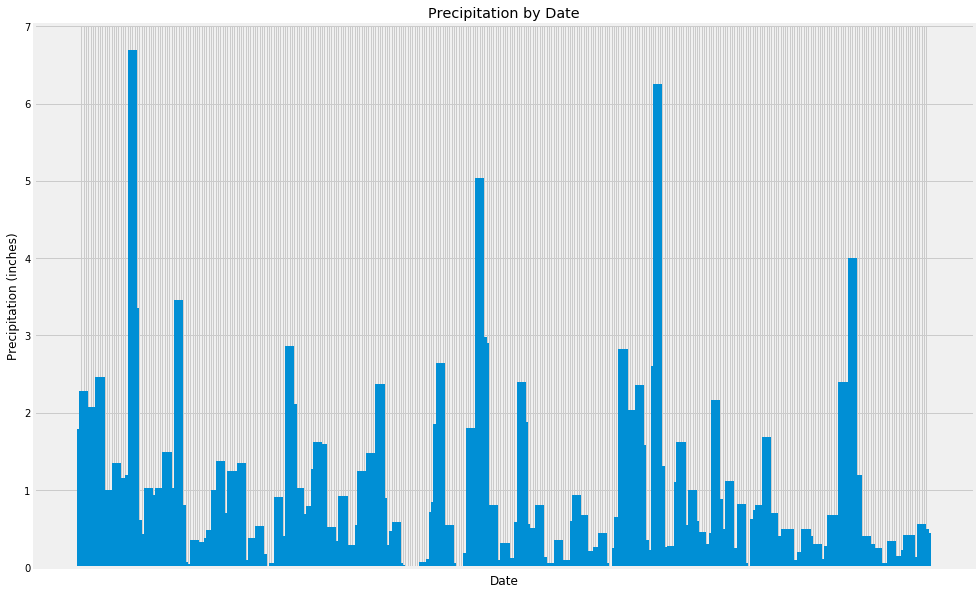

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(15,10))
ax = plt.axes()
ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.bar(query_df.index, query_df['prcp'],width=4)
plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)');


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?

print('From Station table    : Number of stations recorded in the dataset is '
     f'{session.query(Station).count()}')

print('From Measurment table : Number of stations recorded in the dataset is '
     f'{session.query(func.count(distinct(Measurement.station))).scalar()}')


From Station table    : Number of stations recorded in the dataset is 9
From Measurment table : Number of stations recorded in the dataset is 9


In [19]:
# Utility function to parameterize the column to count for group by station query from Measurement
def station_cnt (count_column) :
    return session.query(Measurement.station, func.count(count_column).label('count')) \
                  .group_by(Measurement.station).order_by(desc('count'))

In [20]:
# For the most active stations, list the stations and the counts in descending order.
# Use id column to count rows as there will be no NULL values to affect the count.
station_cnt(Measurement.id).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# For the most active station id from the previous query, calculate the 
# lowest temperature recorded, highest temperature recorded, and average temperature
most_active_sta = station_cnt(Measurement.id)[0][0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
       .filter(Measurement.station==most_active_sta).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0,0.5,'Frequency')

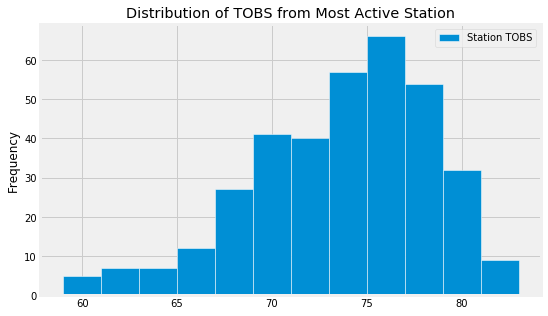

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs_sta = station_cnt(Measurement.tobs)[0][0]
max_date      = session.query(func.max(Measurement.date)).filter(Measurement.station==most_tobs_sta).scalar()
query_date    = date_year_delta(max_date, -1)

data = session.query(Measurement.tobs).filter(Measurement.station==most_tobs_sta)\
                                      .filter(Measurement.date>=query_date)

plt.figure(figsize=(8,5))
plt.hist(np.ravel(data.all()), bins=12,label='Station TOBS',**{'edgecolor':'white'});
plt.legend()
plt.title('Distribution of TOBS from Most Active Station')
plt.ylabel('Frequency')

In [23]:
# Display observation dates range for each station
session.query(Measurement.station,func.max(Measurement.date).label('date'),func.min(Measurement.date))\
       .group_by(Measurement.station)\
       .order_by(desc('date')).all()

[('USC00514830', '2017-08-23', '2010-03-01'),
 ('USC00516128', '2017-08-23', '2010-01-01'),
 ('USC00519397', '2017-08-23', '2010-01-01'),
 ('USC00519523', '2017-08-23', '2010-01-01'),
 ('USC00519281', '2017-08-18', '2010-01-01'),
 ('USC00513117', '2017-07-31', '2010-01-01'),
 ('USC00517948', '2017-07-31', '2010-05-03'),
 ('USC00518838', '2015-11-20', '2010-01-01'),
 ('USC00511918', '2015-10-30', '2010-01-01')]

## Temperature Analysis (Optional)

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-03-31','2017-04-15'))

[(67.0, 74.52941176470588, 82.0)]


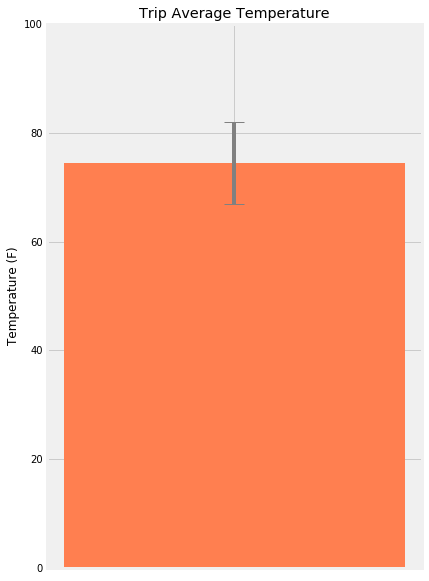

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t_min, t_avg, t_max = calc_temps('2017-03-31','2017-04-15')[0]
plt.figure(figsize=(6,10))
#plt.bar(0,t_avg,width=6.0,color='coral',tick_label="",xerr=t_avg-t_min, yerr=t_max-t_avg, ecolor='blue',error_kw={'fmt':'none'})
plt.bar(0, t_avg, width=0.2, color='coral', tick_label="")
plt.errorbar(0, t_avg, yerr=[[t_avg-t_min],[t_max-t_avg]], fmt='grey',capsize=10)
plt.ylim(0,100)
plt.title('Trip Average Temperature')
plt.ylabel('Temperature (F)');

## Other Recommended Analysis (Optional)

In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
m = Measurement  # Shortcut for Measurment table
s = Station      # Shortcut for Station table
q = session.query(m.station, func.sum(m.prcp).label('prcp'),\
                  s.name, s.latitude, s.longitude, s.elevation)\
       .filter(m.station==s.station)\
       .filter(m.date>='2017-03-30',m.date<='2017-04-15')\
       .group_by(m.station)\
       .order_by(desc('prcp'))
print(q.all())

[('USC00516128', 5.75, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('USC00519281', 4.1899999999999995, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('USC00513117', 1.72, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('USC00514830', 0.9299999999999999, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('USC00519523', 0.36, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), ('USC00519397', 0.27, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment - Vacation Pre-check

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
            Args:
                date (str): A date string in the format '%m-%d'
            Returns:
                A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
v_start = dt.datetime.strptime('2019-03-31', '%Y-%m-%d')
v_end   = dt.datetime.strptime('2019-04-14', '%Y-%m-%d')
v_cnt   = v_end - v_start

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
v_days = [dt.datetime.strftime(v_start + dt.timedelta(days=x),'%m-%d') for x in range(v_cnt.days+1)]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [list(daily_normals(v_days[i])[0]) for i in range(v_cnt.days+1)]
normals = [{['min', 'avg', 'max'][j]:[normals[i][0] for i in range(v_cnt.days+1)] for j in range(3)}]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

ndf = pd.DataFrame(normals[0], index=v_days)
ndf

,min,avg,max
03-31,61.0,61.0,61.0
04-01,60.0,60.0,60.0
04-02,53.0,53.0,53.0
04-03,55.0,55.0,55.0
04-04,58.0,58.0,58.0
04-05,61.0,61.0,61.0
04-06,67.0,67.0,67.0
04-07,63.0,63.0,63.0
04-08,66.0,66.0,66.0
04-09,62.0,62.0,62.0


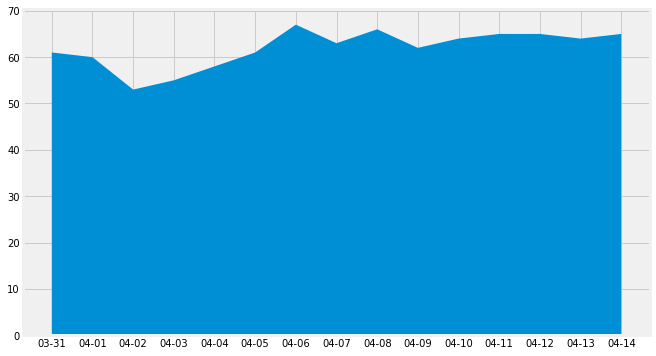

In [32]:
# Plot the daily normals as an area plot with `stacked=False`

ndf['avg_d'] = ndf['avg']-ndf['min']
ndf['max_d'] = ndf['max']-ndf['avg']
plt.figure(figsize=(10,6))
plt.stackplot(ndf.index, ndf['min'], ndf['avg_d'], ndf['max_d']);